# Plot Correlations between Workloads

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import figsizes, bundles
from plotting_utils import read_data_from_logs, MAX_BUDGETS
from performance_profile import get_workloads_time_to_target, BASE_WORKLOADS, get_base_workload_name
from performance_profile import compute_performance_profiles
from score_submissions import compute_leaderboard_score

/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Loading

In [2]:
log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
log_path_self_tuning = os.path.join(log_path, "self_tuning")
log_path_external_tuning = os.path.join(log_path, "external_tuning")

full_results_self_tuning = read_data_from_logs(log_path_self_tuning)
full_results_external_tuning = read_data_from_logs(log_path_external_tuning)

Reading data for submission: prize_qualification_baseline
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_i

In [3]:
for k in ["prize_qualification_baseline", "schedule_free_adamw"]:
    new_k = k + "_self"
    full_results_self_tuning[new_k] = full_results_self_tuning[k]
    del full_results_self_tuning[k]

In [4]:
def get_workload_runtimes(full_results, self_tuning=False):
  dfs = []
  for submission_name, submission_results in full_results.items():
    # Get time to targets for each submission across studies and trials
    dfs.append(
        get_workloads_time_to_target(
            submission_results,
            submission_name,
            "score",
            self_tuning_ruleset=self_tuning))
  df = pd.concat(dfs).transpose()
  # Split into base and held-out workloads
  df_base = df.loc[BASE_WORKLOADS]
  return df_base

def normalize_by_budget(row):
  workload_name = row.name
  if workload_name not in MAX_BUDGETS:
    workload_name = get_base_workload_name(workload_name)
  budget = MAX_BUDGETS[workload_name]
  return row / budget


runtimes_base_ext = get_workload_runtimes(full_results_external_tuning)
runtimes_base_self = get_workload_runtimes(full_results_self_tuning, self_tuning=True)

runtimes_base = runtimes_base_self.transpose().apply(normalize_by_budget, axis=0)

# runtimes_base

2024-09-25 12:52:44.990815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Compute Pairwise Correlation

In [5]:
pairwise_corr = runtimes_base.corr(method="pearson", numeric_only=True)

workload_rename_dict = {
      "criteo1tb": "Criteo 1TB",
      "fastmri": "fastMRI",
      "imagenet_resnet": "ResNet",
      "imagenet_vit": "ViT",
      "librispeech_conformer": "Conformer",
      "librispeech_deepspeech": "DeepSpeech",
      "ogbg": "OGBG",
      "wmt": "WMT",
  }

pairwise_corr.rename(columns=workload_rename_dict, inplace=True)
pairwise_corr.rename(index=workload_rename_dict, inplace=True)
pairwise_corr

workload,Criteo 1TB,fastMRI,ResNet,ViT,Conformer,DeepSpeech,OGBG,WMT
workload,,,,,,,,
Criteo 1TB,1.000000,0.791496,NaN,0.953962,-1.0,0.958954,0.810433,0.998018
fastMRI,0.791496,1.000000,NaN,0.938365,-1.0,0.585703,0.972704,0.693143
ResNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViT,0.953962,0.938365,NaN,1.000000,-1.0,0.829758,0.948829,0.933199
Conformer,-1.000000,-1.000000,NaN,-1.000000,1.0,1.000000,-1.000000,1.000000
DeepSpeech,0.958954,0.585703,NaN,0.829758,1.0,1.000000,0.611049,0.974896
OGBG,0.810433,0.972704,NaN,0.948829,-1.0,0.611049,1.000000,0.578288
WMT,0.998018,0.693143,NaN,0.933199,1.0,0.974896,0.578288,1.000000


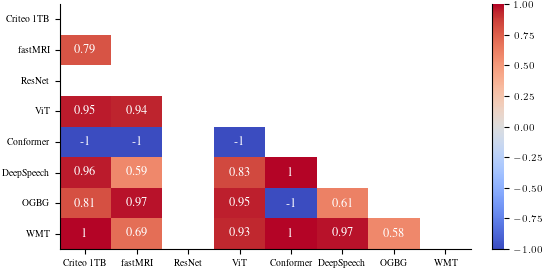

In [6]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(pairwise_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
pairwise_corr[mask] = np.nan

with plt.rc_context(
    {**bundles.iclr2024(), **figsizes.iclr2024(height_to_width_ratio=1)}):

    fig, ax = plt.subplots()
    sns.heatmap(pairwise_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.grid(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine()
    plt.savefig("plots/pairwise_correlations.png", dpi=300)
    plt.show()

0.9727036009811705 0.00539145106735361


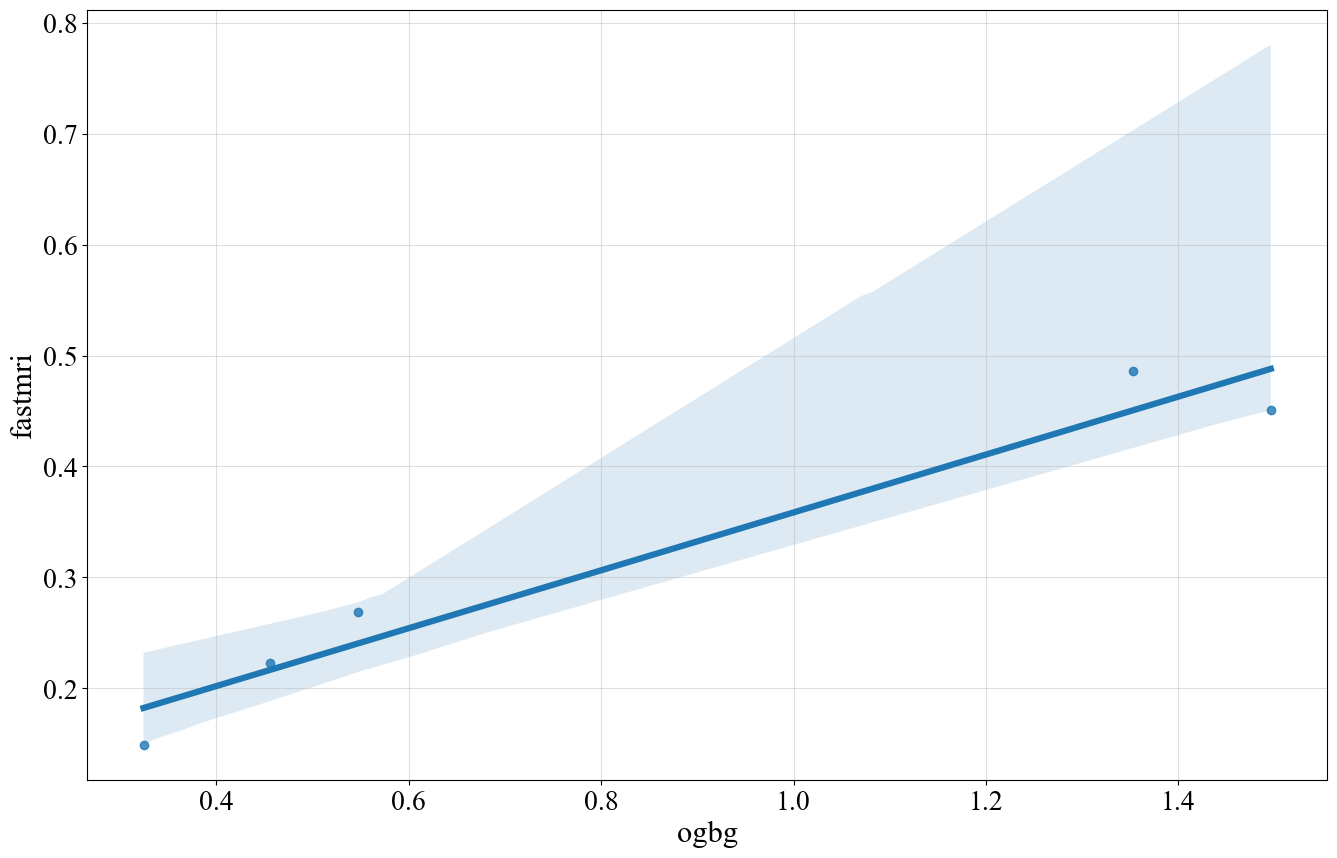

In [7]:
import scipy as sp
x_workload = "ogbg"
y_workload = "fastmri"
x = runtimes_base[x_workload]
y = runtimes_base[y_workload]

# Combine the series into a DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Remove rows with inf or nan values in either series
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# The cleaned series can be extracted from the DataFrame
x = df['x']
y = df['y']


# plt.scatter(x, y)
sns.regplot(data=df, x="x", y="y")
ax = plt.gca()
ax.set_xlabel(x_workload)
ax.set_ylabel(y_workload)
r, p = sp.stats.pearsonr(x, y)
print(r, p)
plt.show()

## Compute Scores and Ranks when dropping Workloads

In [3]:
performance_profile_df = compute_performance_profiles(
        full_results_external_tuning,
        time_col='score',
        min_tau=1.0,
        max_tau=4.0,
        reference_submission_tag=None,
        num_points=100,
        scale='linear',
        verbosity=0,
        self_tuning_ruleset=False,
        strict=False)

scores = compute_leaderboard_score(performance_profile_df)

for ignore_workload in BASE_WORKLOADS:

    performance_profile_df = compute_performance_profiles(
        full_results_external_tuning.copy(),
        time_col='score',
        min_tau=1.0,
        max_tau=4.0,
        reference_submission_tag=None,
        num_points=100,
        scale='linear',
        verbosity=0,
        self_tuning_ruleset=False,
        strict=False,
        ignore_workload=ignore_workload)

    modified_scores = compute_leaderboard_score(performance_profile_df)
    scores[ignore_workload] = modified_scores

2024-09-25 15:14:47.493945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Renaming the "score" column to "all workloads"
scores.rename(columns={"score": "all workloads"}, inplace=True)

# Compute the rank
ranks = scores.rank(axis=0, ascending=False)

# scores.corr(method="spearman")["all workloads"]

# ranks.transpose().plot(kind='line')
# plt.show()

In [6]:
# Create a new dataframe with multi-level columns combining the score and rank
score_rank_df = pd.DataFrame(index=scores.index)

# Create the multi-index columns
columns = pd.MultiIndex.from_product([scores.columns, ['score', 'rank']], names=['Dataset', 'Metric'])

# Initialize the DataFrame with the correct shape and column names
score_rank_df = pd.DataFrame(index=scores.index, columns=columns)

# Populate the columns
for dataset in scores.columns:
    score_rank_df.loc[:, (dataset, 'score')] = scores[dataset]
    score_rank_df.loc[:, (dataset, 'rank')] = ranks[dataset]
    # Change the rank column to be integers
    score_rank_df.loc[:, (dataset, 'rank')] = score_rank_df.loc[:, (dataset, 'rank')].astype(int)

workload_rename_dict = {
      "criteo1tb": r"\criteo",
      "fastmri": r"\fastmri",
      "imagenet_resnet": r"\resnet",
      "imagenet_vit": r"\vit",
      "librispeech_conformer": r"\conformer",
      "librispeech_deepspeech": r"\makecell{\textsc{Deep}\\ \textsc{Speech}}",
      "ogbg": r"\ogbg",
      "wmt": r"\wmt",
  }
submission_rename_dict = {
    "shampoo_submission": r"\shampoo \newline \textsc{Submission}",
    "prize_qualification_baseline": r"\baseline",
    "caspr_adaptive": r"\textsc{CASPR} \newline \textsc{Adaptive}",
    "schedule_free_adamw": r"\sfadam",
    "schedule_free_prodigy": r"\sfprodigy",
    "amos": r"\amos",
    "lawa_ema": r"\lawaema",
    "lawa_queue": r"\lawaq",
    "cyclic_lr": r"\cycliclr",
    "generalized_adam": r"\generalizedadam",
    "nadamp": r"\nadamp",
    "AdamG": r"\adamg",
    "sinv6_75": r"\sinvnum",
    "sinv6": r"\sinv",
    "nadamw_sequential": r"\textsc{NadamW}\newline \textsc{Sequential}",
}
score_rank_df.rename(columns=workload_rename_dict, inplace=True)
score_rank_df.rename(index=submission_rename_dict, inplace=True)
# Sort rows by "all workloads" rank
score_rank_df = score_rank_df.sort_values(by=("all workloads", "rank"), ascending=True)
print(score_rank_df.to_latex(float_format="%.2f"))

\begin{tabular}{lllllllllllllllllll}
\toprule
Dataset & \multicolumn{2}{r}{all workloads} & \multicolumn{2}{r}{\criteo} & \multicolumn{2}{r}{\fastmri} & \multicolumn{2}{r}{\resnet} & \multicolumn{2}{r}{\vit} & \multicolumn{2}{r}{\conformer} & \multicolumn{2}{r}{\makecell{\textsc{Deep}\\ \textsc{Speech}}} & \multicolumn{2}{r}{\ogbg} & \multicolumn{2}{r}{\wmt} \\
Metric & score & rank & score & rank & score & rank & score & rank & score & rank & score & rank & score & rank & score & rank & score & rank \\
submission &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\shampoo \newline \textsc{Submission} & 0.78 & 1 & 0.75 & 1 & 0.75 & 1 & 0.89 & 1 & 0.75 & 1 & 0.75 & 1 & 0.75 & 1 & 0.77 & 2 & 0.81 & 1 \\
\sfadam & 0.71 & 2 & 0.67 & 2 & 0.67 & 2 & 0.81 & 2 & 0.68 & 2 & 0.68 & 3 & 0.68 & 2 & 0.81 & 1 & 0.67 & 2 \\
\generalizedadam & 0.64 & 3 & 0.60 & 3 & 0.61 & 4 & 0.59 & 6 & 0.63 & 3 & 0.73 & 2 & 0.59 & 3 & 0.73 & 3 & 0.63 & 3 \\
\cycliclr & 0.63 & 4 & 0.58 & 4 & 0.62 & 3 & 